# Geometric-Exponential Compound Sums

Consider a basic insurance example where each month our insurance company receives a random number of claims, each of which is of a random size.
Specifically, say that in month $i$ we have $N_i \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Geometric}(p)$ number of claims, and each claim is $U_{i,j} \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Exponential}(\lambda = 1/\delta)$ sized.

At each month we can observe the aggregate claims, that is,
$ X_i = \sum_{j=1}^{N_i} U_{i,j} $
for $i=1,\dots,T$, that is, we observe $T$ months of data.

In this scenario, the likelihood of the $X_i$'s is tractable, so it is a useful test case to compare ABC against more traditional fitting methods, like Markov Chain Monte Carlo (MCMC) and Maximum Likelihood Estimation (MLE).

## Generating some synthetic data to fit

We start by importing some necessary packages.

In [1]:
%config InlineBackend.figure_format = 'retina'
import approxbayescomp as abc
import numpy as np
import numpy.random as rnd

We will fit simulated data, so that we know the true value of the parameters for the data-generating process.
Here, we start with $p = 0.8$, and $\delta = 5$, and say that we observe $T = 100$ i.i.d. observations of the compound sum.

In [2]:
# Create a pseudorandom number generator
rg = rnd.default_rng(1234)

# Parameters of the true model
freq = "geometric"
sev = "exponential"
trueTheta = (0.8, 5)

# Setting the time horizon
T = 100

Inside `approxbayescomp`, generating this compound sum is done in two steps.
Firstly, we generate the entire claims process:

In [3]:
# Simulating the claim data
freqs, sevs = abc.simulate_claim_data(rg, T, freq, sev, trueTheta)

So `freqs` contains the $\{ N_i \}_{i=1,\dots,T}$, and `sevs` contains the $\{ U_{i,j} \}_{i=1,\dots,T, j=1,\dots,N_i }$.
For example:

In [4]:
freqs

array([ 6,  3,  8,  3,  4,  1,  0,  1,  6,  4,  7, 23, 11,  1,  2,  3, 14,
        0,  0, 12,  0, 16,  2,  4,  0,  3,  5,  0,  0,  3,  5,  4,  6,  4,
        3,  7,  2,  9,  0, 10,  1,  2,  9,  6, 13,  6,  2,  6,  1,  0,  2,
        3,  4,  2,  9,  2,  2,  2,  4, 13,  3,  9,  3,  5,  0,  3,  2,  1,
        3,  1, 14,  0,  3,  5,  0,  0,  4,  1,  5,  0,  0,  0,  6,  1,  1,
        0,  9,  2,  1,  1,  7,  0,  0,  0,  1, 10,  2, 20,  4,  0])

In [5]:
sevs[0:6]

array([ 0.53075068,  8.74170314,  1.93800992,  1.23094078,  3.07323683,
       12.37846317])

Note, the `sevs` vector contains all the claims sizes (a.k.a. severities) for all time periods in one long vector.
That is, the length of `sevs` will be `np.sum(freqs)` long.
This is to save computational time in the ABC algorithm, as the `simulate_claim_data` function is called many times.

Then the $\Psi$ operation is applied to produce a single value for each time period.
Here, this means that we observe the sum of all the claims in each period, however `psi` can be set to handle censored values like stop-loss observations.

In [6]:
# Simulating the observed data
psi = abc.Psi("sum")
xData = abc.compute_psi(freqs, sevs, psi)

In [7]:
xData

array([ 27.89310452,  17.68445011,  43.97815086,  10.40718159,
         8.81323352,   2.91015669,   0.        ,   0.73331647,
        54.66211006,  15.40214731,  97.62341685,  68.75165795,
        41.72228953,  16.97354716,  15.02697784,   9.2411639 ,
        71.63352158,   0.        ,   0.        ,  47.31622624,
         0.        ,  43.97581615,   0.9500043 ,  28.01171543,
         0.        ,   6.39736742,  34.87762318,   0.        ,
         0.        ,  13.20533558,  19.67856556,  20.78462773,
        31.03229256,  16.08706747,   7.63900497,  40.2456368 ,
        17.32230075,  38.54744184,   0.        ,  51.08710316,
         2.37910798,   4.61828744,  65.38123231,  35.85594666,
        98.43324628,  19.38163374,   6.45563628,  12.0755808 ,
         0.90372386,   0.        ,   8.29971217,  29.44775501,
        23.33491296,  25.80718148,  12.5482116 ,  10.15175395,
        26.38410576,  38.06253589,  52.00790943,  82.63320756,
        10.04313675,  39.01542845,  11.83534301,  24.36

The observed values can include many zero values, as the compound distribution has an atom as 0.

In [8]:
print("Number of zeros:", np.sum(xData == 0))

Number of zeros: 21


## Use ABC to fit the data

With this data, we create objects to represent the data-generating process (the model) and the prior distribution.
The priors are simply that $p \sim \mathsf{Unif}(0, 1)$ and $\delta \sim \mathsf{Unif}(0, 100).$

In [9]:
model = abc.Model(freq, sev, psi)
params = ("$p$", "$\\delta$")
prior = abc.IndependentUniformPrior([(0, 1), (0, 100)], params)

After, we call the main `smc` method which is provided by `approxbayescomp` to fit the observed `xData`.

### Ignoring the zeros

In [10]:
numIters = 9
popSize = 100
%time fit = abc.smc(numIters, popSize, xData, model, prior, seed=1)

CPU times: user 2.49 s, sys: 33.1 ms, total: 2.53 s
Wall time: 2.52 s


These particles all generated fake data within the following distance to the observed data:

In [11]:
np.max(fit.dists)

1.7046419698737312

Plotting the fitted ABC posterior:

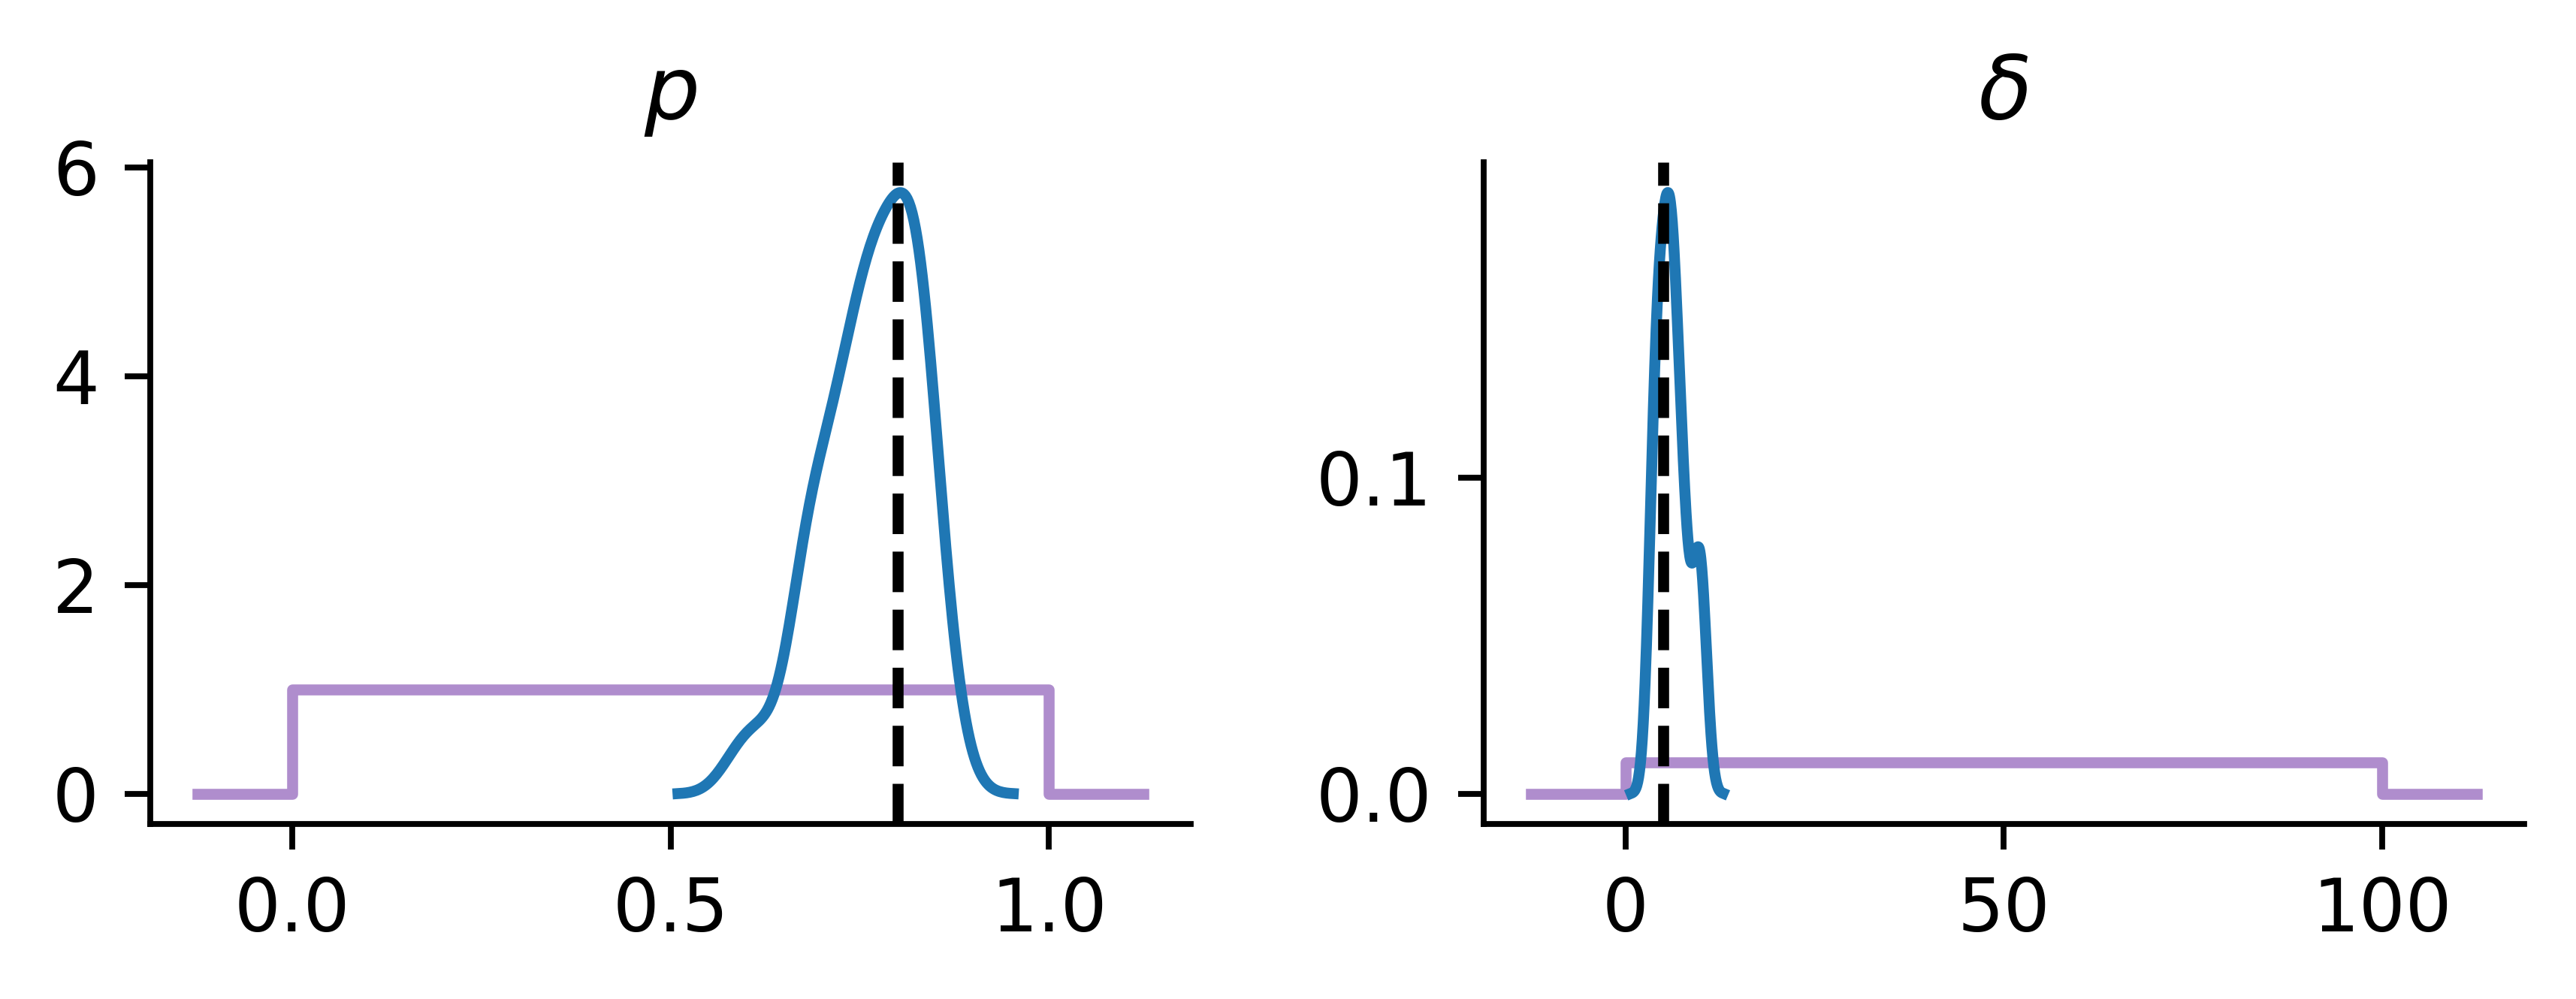

In [12]:
abc.plot_posteriors(fit, prior, refLines=trueTheta)

### Matching the zeros

Technically, the theory behind ABC doesn't like the fact that the compound distribution we're fitting is a combination of a continuous distribution and a discrete atom (at 0).
The theory says that we should reject fake data which contains a different number of zero observations as the observed data.
This behaviour can be enabled by the `matchZeros` flag.
When the observed data contains zeros, enabling `matchZeros` should increase the accuracy of the fits, though it will significantly increase the computational time.

In [13]:
%time fitMatchZeros = abc.smc(numIters, popSize, xData, model, prior, matchZeros=True, seed=1)

CPU times: user 2min 22s, sys: 2.91 ms, total: 2min 22s
Wall time: 2min 22s


These particles all generated fake data within the following distance to the observed data:

In [14]:
np.max(fitMatchZeros.dists)

1.17809471598958

Plotting the fitted ABC posterior:

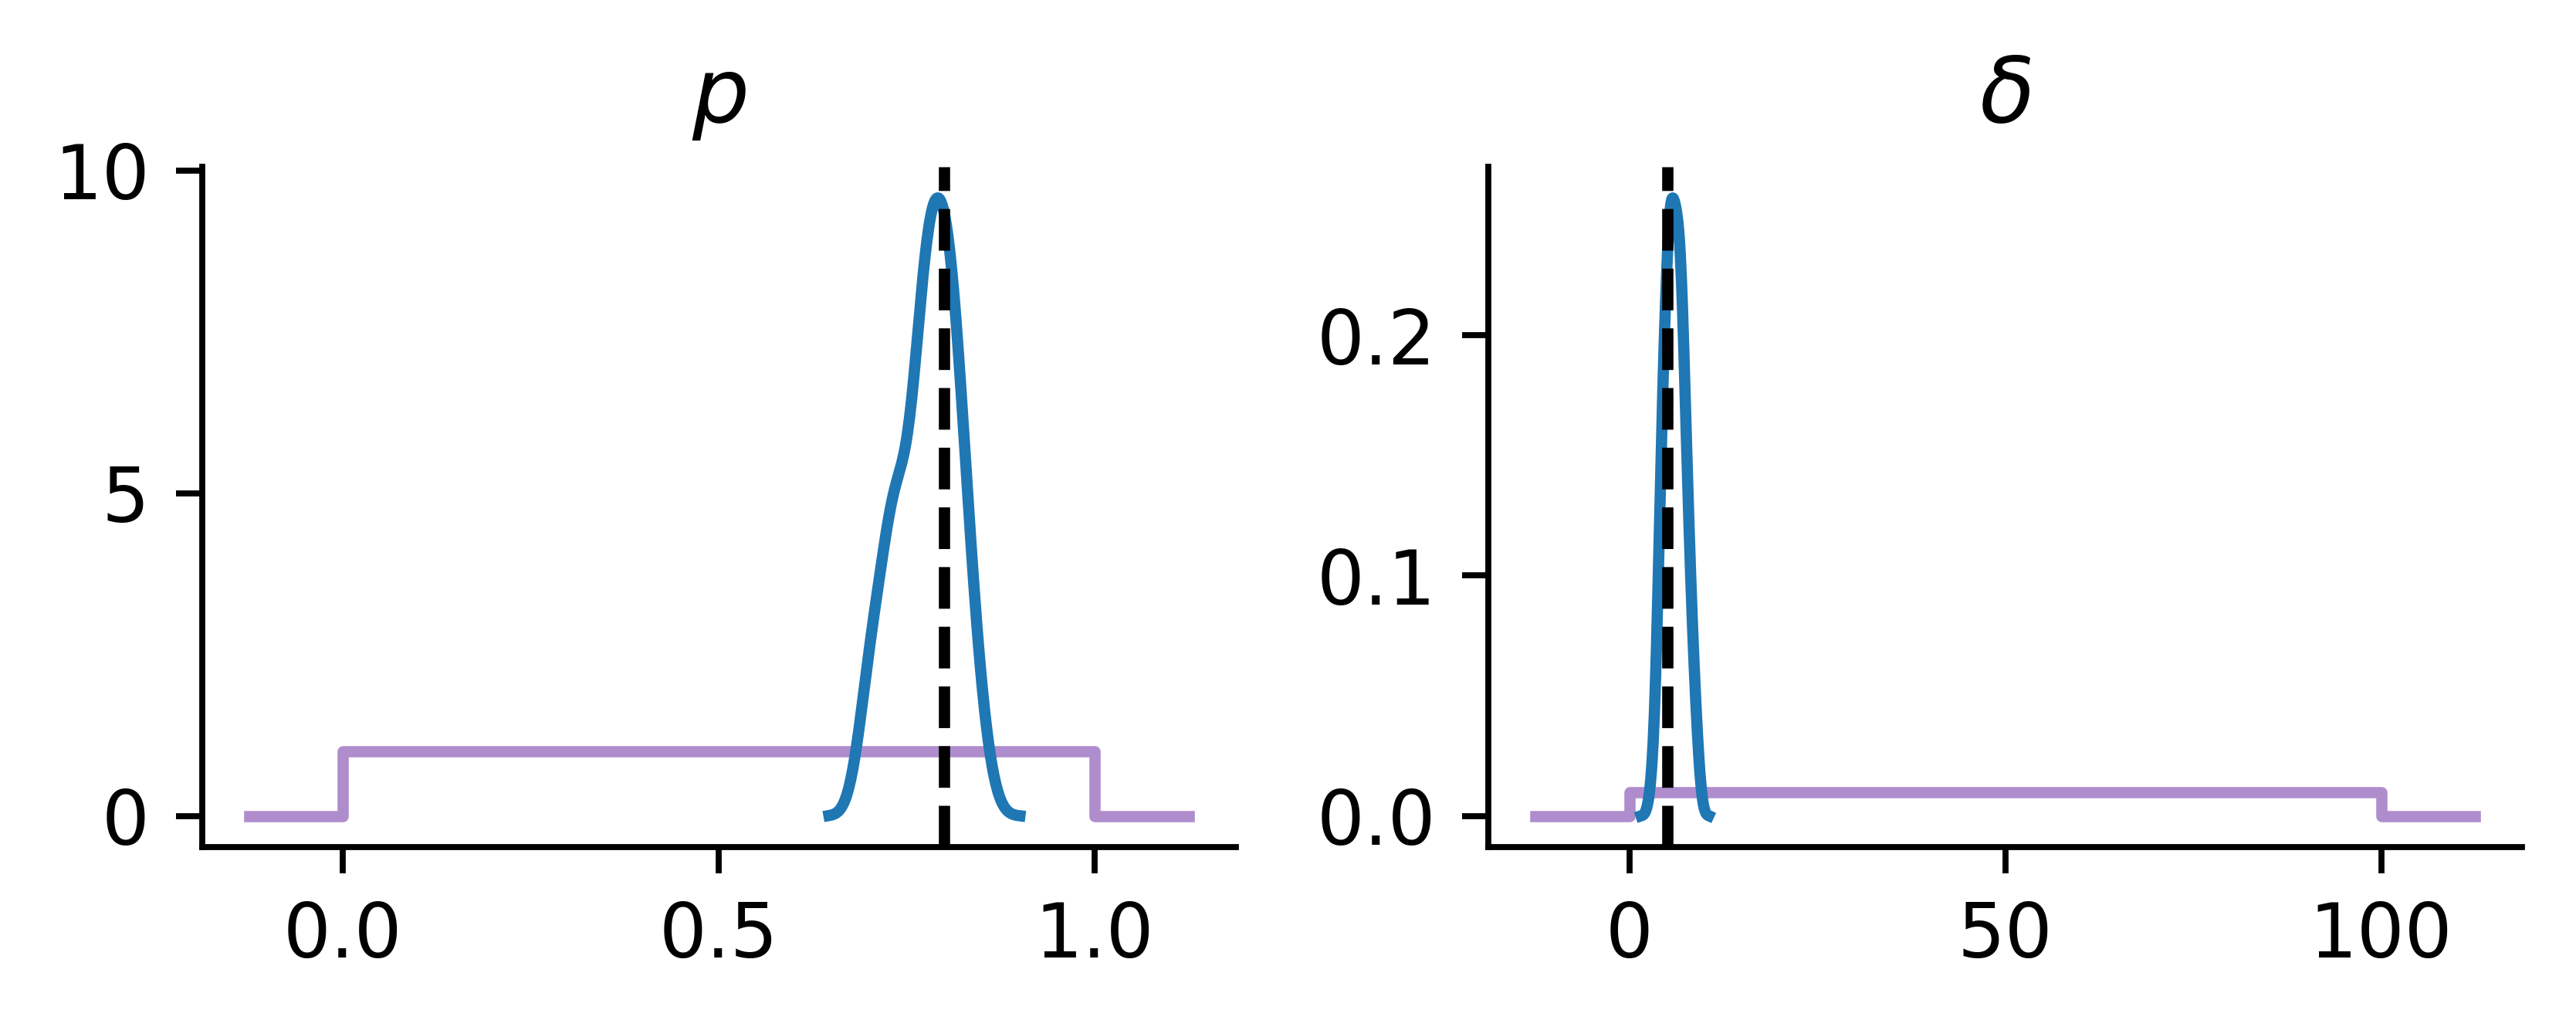

In [15]:
abc.plot_posteriors(
    fitMatchZeros, prior, refLines=trueTheta
)

As expected, the particles generated with `matchZeros=True` are better quality particles which generate a more accurate ABC posterior, though they required more computational time to obtain.

## Comparing against MCMC with PyMC3

As the likelihood for this simple/special case is tractable, we can fit the data using the standard Markov Chain Monte Carlo method via `PyMC3`:

In [16]:
import pymc3 as pm

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    p = pm.Uniform("p", 0, 1)
    δ = pm.Uniform("δ", 0, 100)

    # Log probability of the compound-sum variable
    def logp(t0, sumData):
        return T * np.log(1 - p) + (T - t0) * np.log(p / δ) - (1 - p) / δ * sumData

    exp_surv = pm.DensityDist(
        "X", logp, observed={"t0": np.sum(xData == 0), "sumData": np.sum(xData)}
    )

    trace = pm.sample(
        1000, tune=500, chains=1, random_seed=1, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [δ, p]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Comparing this 'true' MCMC posterior to the 'approximate' ABC posterior we can see there is quite a strong agreement between the two:

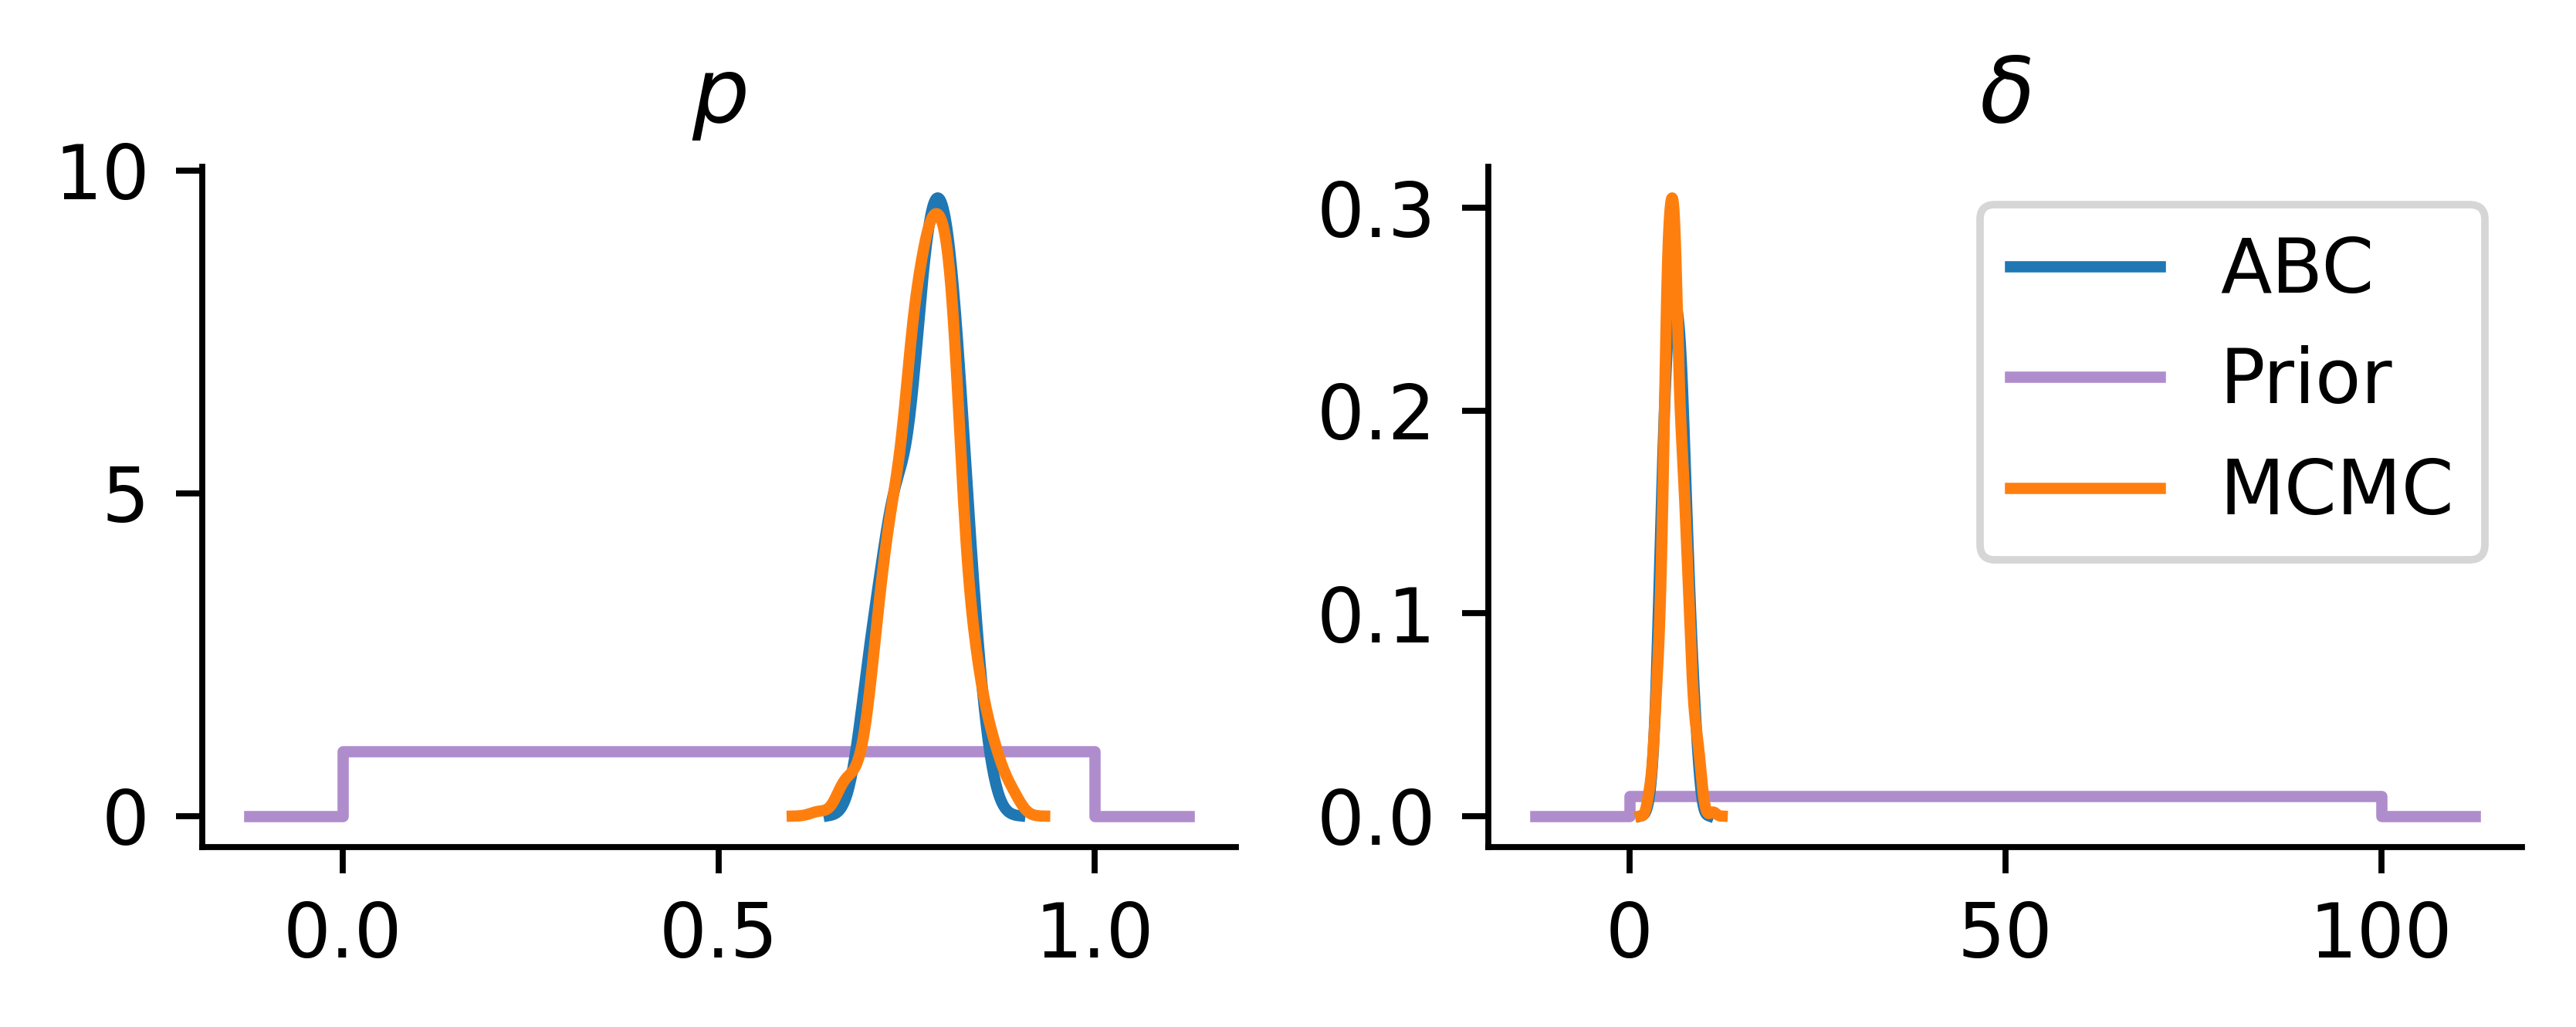

In [17]:
import matplotlib.pyplot as plt

abc.plot_posteriors(fitMatchZeros, prior)

fig = plt.gcf()
axs = fig.axes

for l, param in enumerate(["p", "δ"]):
    nMCMC = len(trace.posterior[param][0])
    abc.weighted_distplot(
        trace.posterior[param][0], np.ones(nMCMC) / nMCMC, ax=axs[l], hist=False
    )

plt.legend(["ABC", "Prior", "MCMC"]);